# Symmetric and Asymmetric States

Brummell and Hart (1993) provide a state diagram, figure 4, that shows multiple states all the way up to Ra > 80000. BH93 classify states by the temporal properties of their kinetic energies: 

Code | meaning
---| ---
F | Fixed point (constant energy)
L | Limit cycle (two energies)
T | torus (two frequency)
T2 | period doubled torus
C | Chaos

Using [webplotdigitizer](https://apps.automeris.io/wpd/), I extracted the following values

Branch | Ra | State
---| ---| ---
1S | 41380 | L
1S | 42712 | T
1S | 43601 | C
9A | 33500 | F (start?)
9A | 35422 | L
9S | 31094| F (start?)


Some parameters from our runs

Run | Ra | $\beta$
---| ---| ---
A | 76000 | 2800
E | 36000| 2800

When we start our runs, we typically use noise, which will excite all modes. Here, I show how to restrict the initial conditions to just the symmetric modes (those with $m+n$ even).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import h5py
import dedalus.public as de
import numpy as np

First, load Run E, a symmetric IC run E, and two runs at Ra = 42500 and 45000, both with symmetric ICs

In [61]:
run_E_fn = "scratch/busse_annulus_ra3.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL/snapshots/snapshots_s1.h5"
run_E_sym_fn = "scratch/busse_annulus_ra3.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/snapshots/snapshots_s1.h5"
ra_45000_fn = "scratch/busse_annulus_ra4.50e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/snapshots/snapshots_s1.h5"
ra_42500_fn = "scratch/busse_annulus_ra4.25e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/snapshots/snapshots_s1.h5"

In [62]:
df = h5py.File(run_E_fn,"r")
df_sym = h5py.File(run_E_sym_fn, "r")
df_sym_45 = h5py.File(ra_45000_fn, "r")
df_sym_425 = h5py.File(ra_42500_fn, "r")

<IPython.core.display.Javascript object>


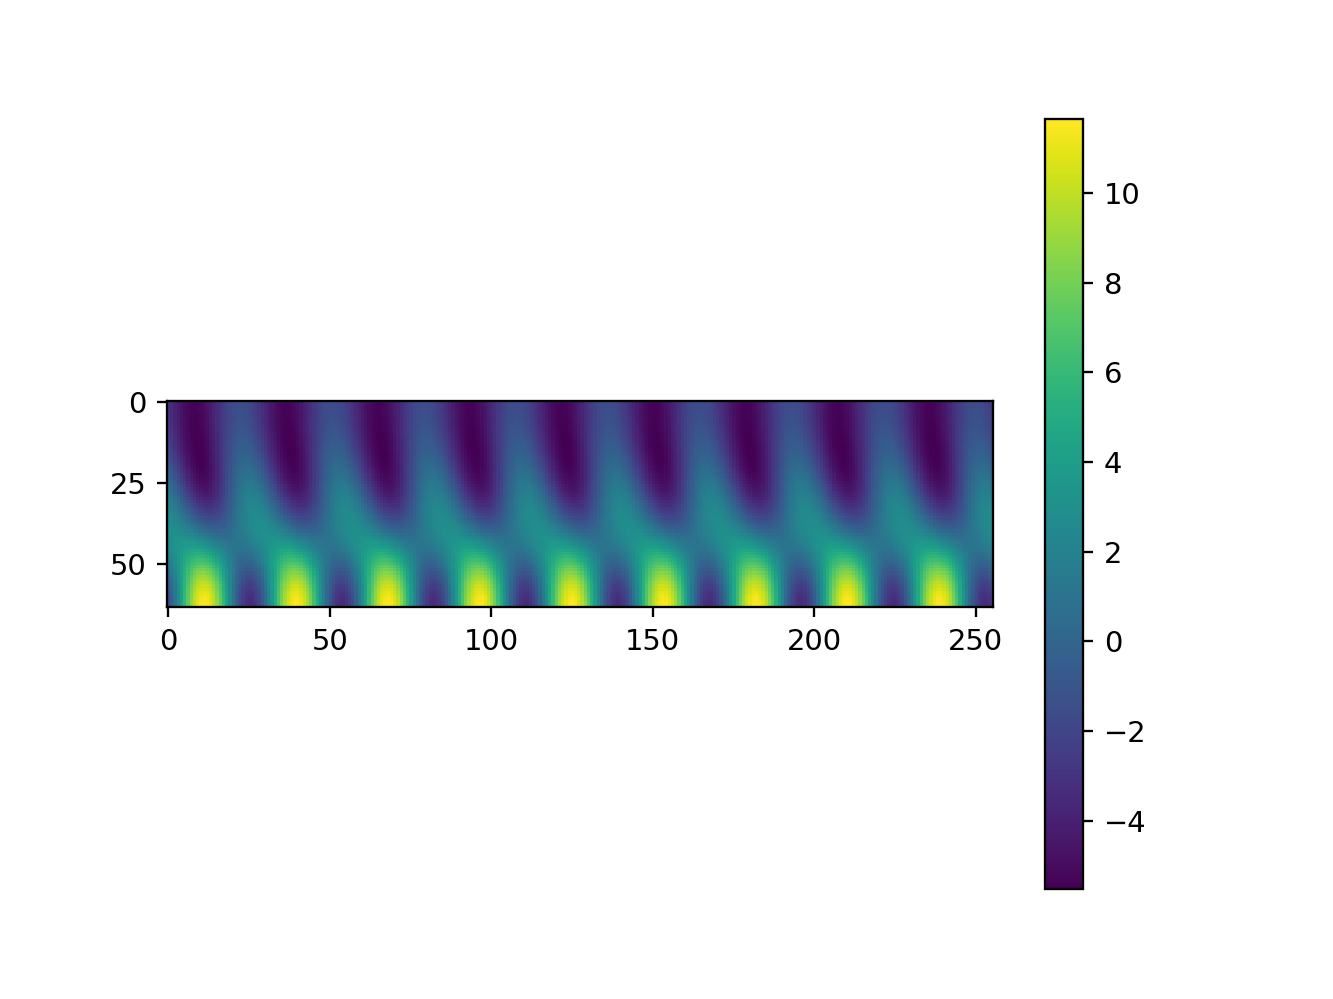

In [3]:
plt.figure()
plt.imshow(df['tasks/u_x'][-1])
plt.colorbar()

So this is asymmetric. Clearly in 9A.

<IPython.core.display.Javascript object>


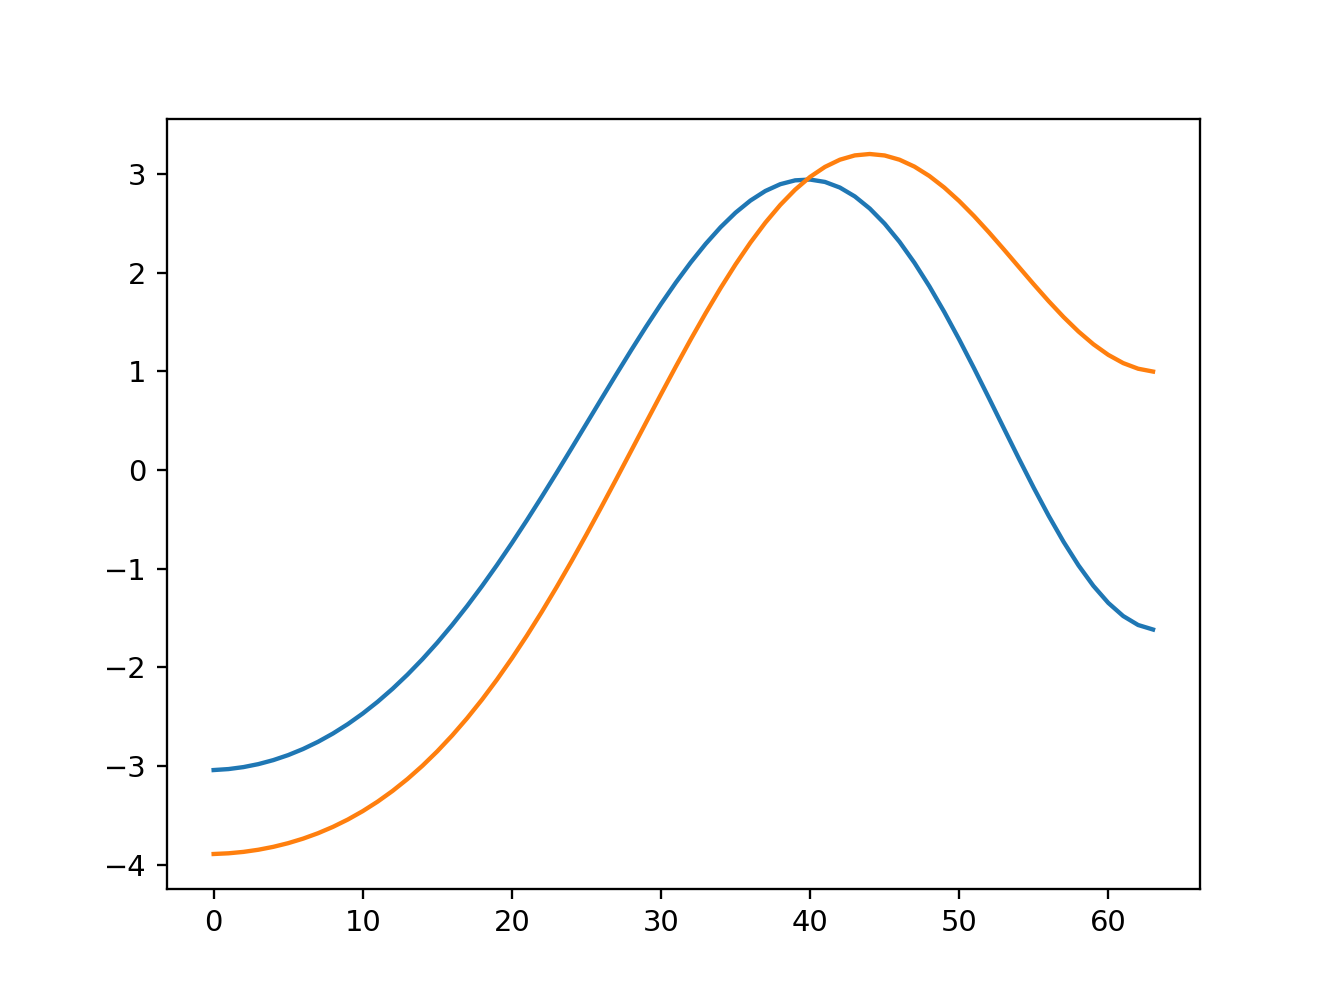

In [4]:
plt.figure()
plt.plot(df['tasks/u_x'][-1,:,0])
plt.plot(df['tasks/u_x'][-1,:,2])

<IPython.core.display.Javascript object>


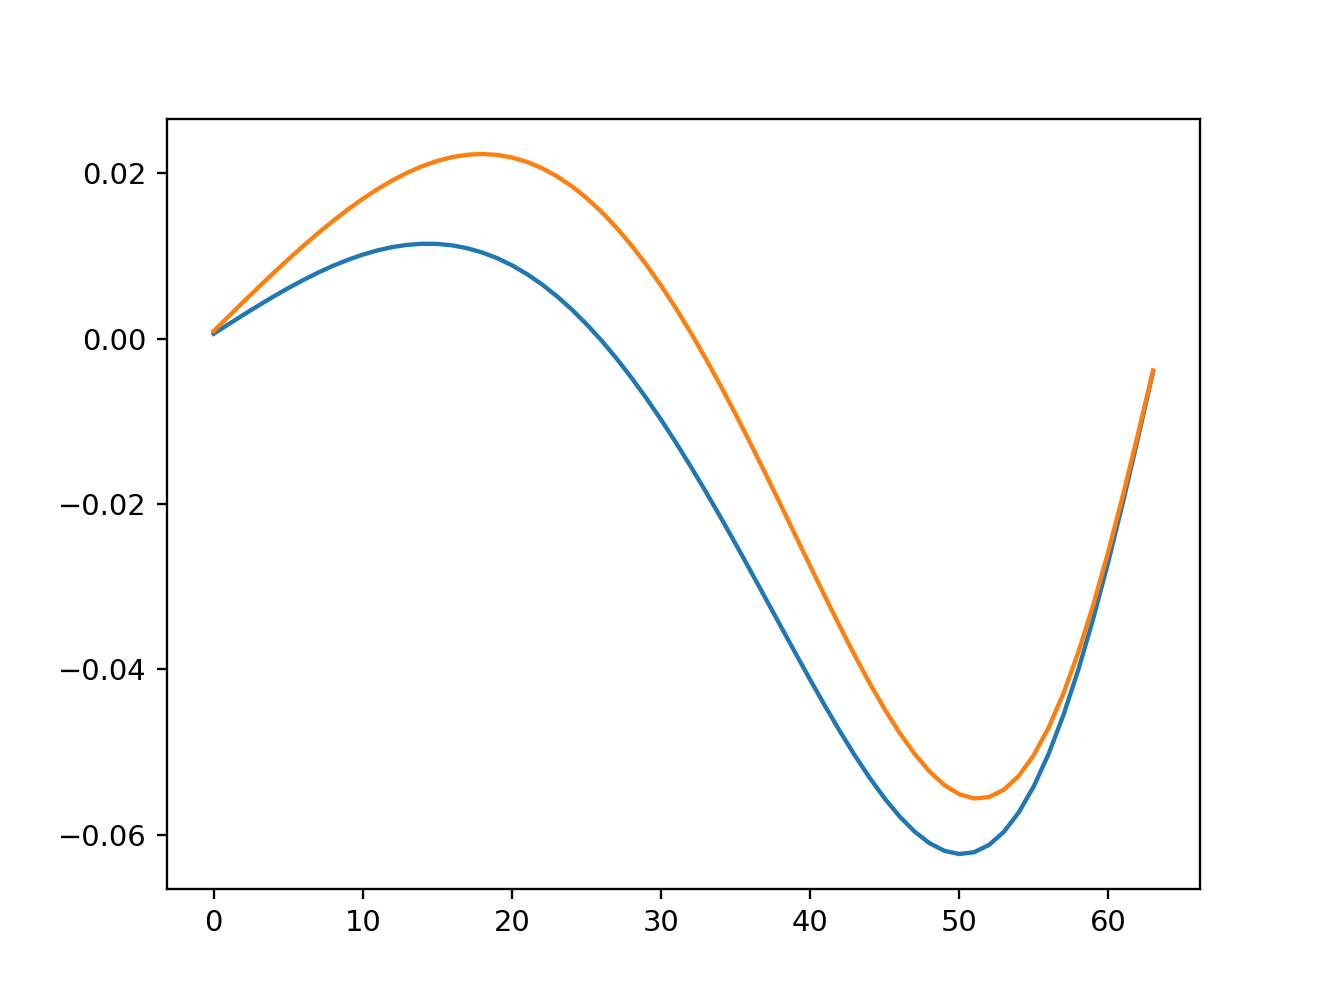

In [5]:
plt.figure()
plt.plot(df['tasks/theta'][-1,:,0])
plt.plot(df['tasks/theta'][-1,:,2])

In [54]:
from file_to_field import field_from_file



In [55]:
def calc_power(field):
    coeff = field['c']
    return (coeff*coeff.conj()).real

In [81]:
def extract_theta_ux_power(filename, index=-1,xy=True):
    if xy:
        bases = ['Fourier','SinCos']
    else:
        bases = ['SinCos','Fourier']
    theta = field_from_file("theta", filename, bases,meta={'y':{'parity':-1,'constant':False}}, index=index)
    u_x = field_from_file("u_x", filename, bases,meta={'y':{'parity':1,'constant':False}},index=index)
    
    t_power = calc_power(theta)
    ux_power = calc_power(u_x)
    
    with h5py.File(filename,"r") as df:
        sim_time = df['scales/sim_time'][index]
    
    return sim_time, t_power, ux_power

In [65]:
run_E_pow = extract_theta_ux_power(run_E_fn)

In [6]:
nt, ny, nx = df['tasks/u_x'].shape

x = de.Fourier('x',nx)
y = de.SinCos('y',ny,interval=[0,1])
d = de.Domain([y,x],grid_dtype='float')

ux = d.new_field(name='ux')
theta = d.new_field(name='theta')

ux.meta['y']['parity'] = 1
theta.meta['y']['parity'] = -1

ux['g'] = df['tasks/u_x'][-1]
theta['g'] = df['tasks/theta'][-1]

ux_spec = (ux['c']*ux['c'].conj()).real
theta_spec = (theta['c']*theta['c'].conj()).real

<IPython.core.display.Javascript object>


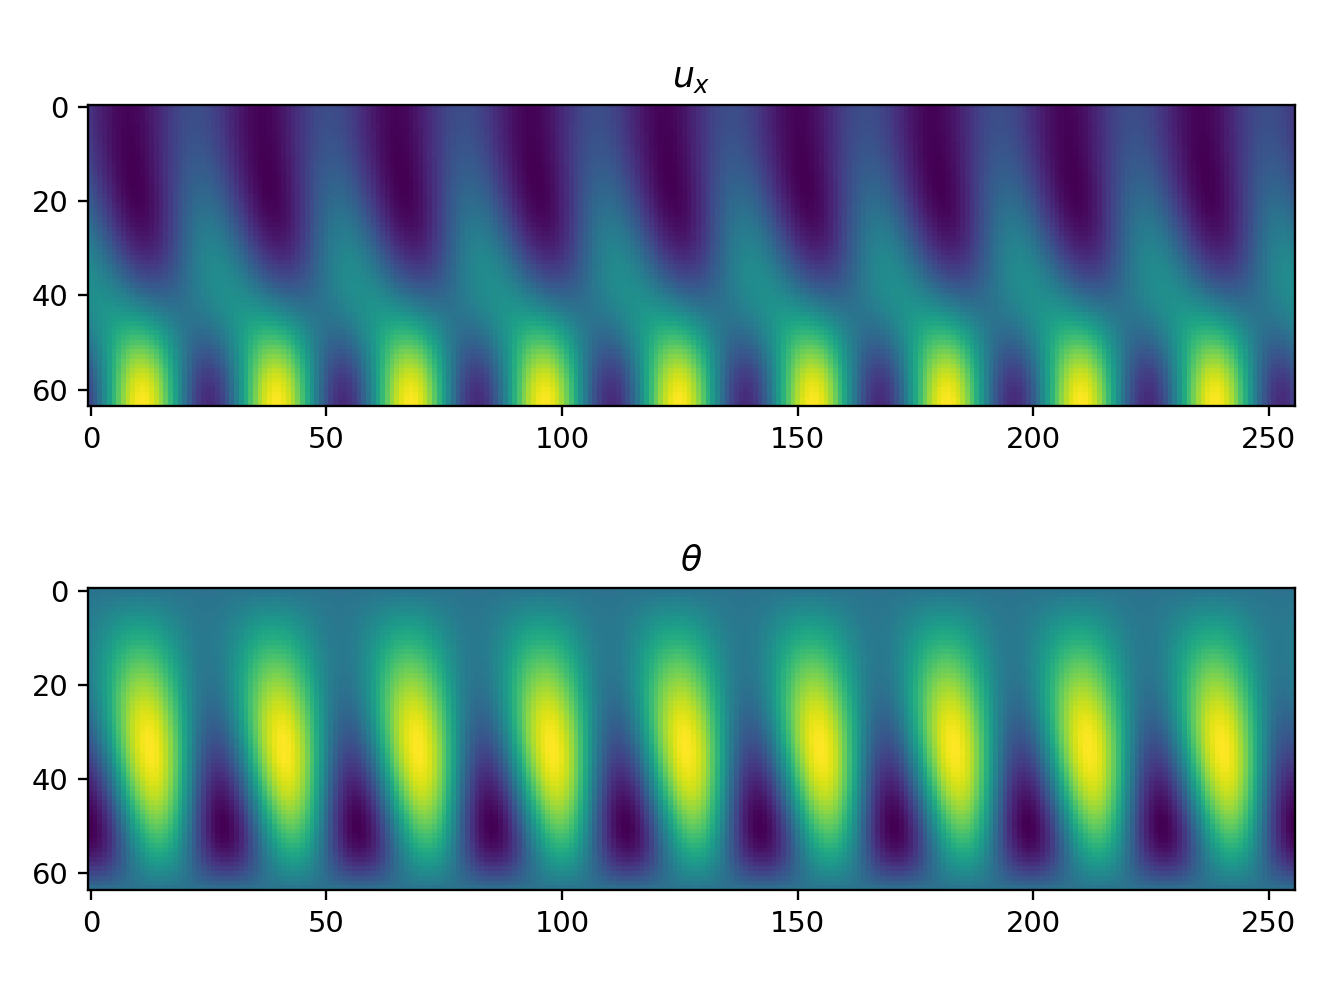

In [7]:
plt.figure()
plt.subplot(211)
plt.imshow(ux['g'])
plt.title(r"$u_x$")
plt.subplot(212)
plt.imshow(theta['g'])
plt.title(r"$\theta$")
plt.tight_layout()

Spectra also show what we expect for asymmetric state: all $n$ modes excited for each excited $m$. White line is at $m= 9$.

<IPython.core.display.Javascript object>


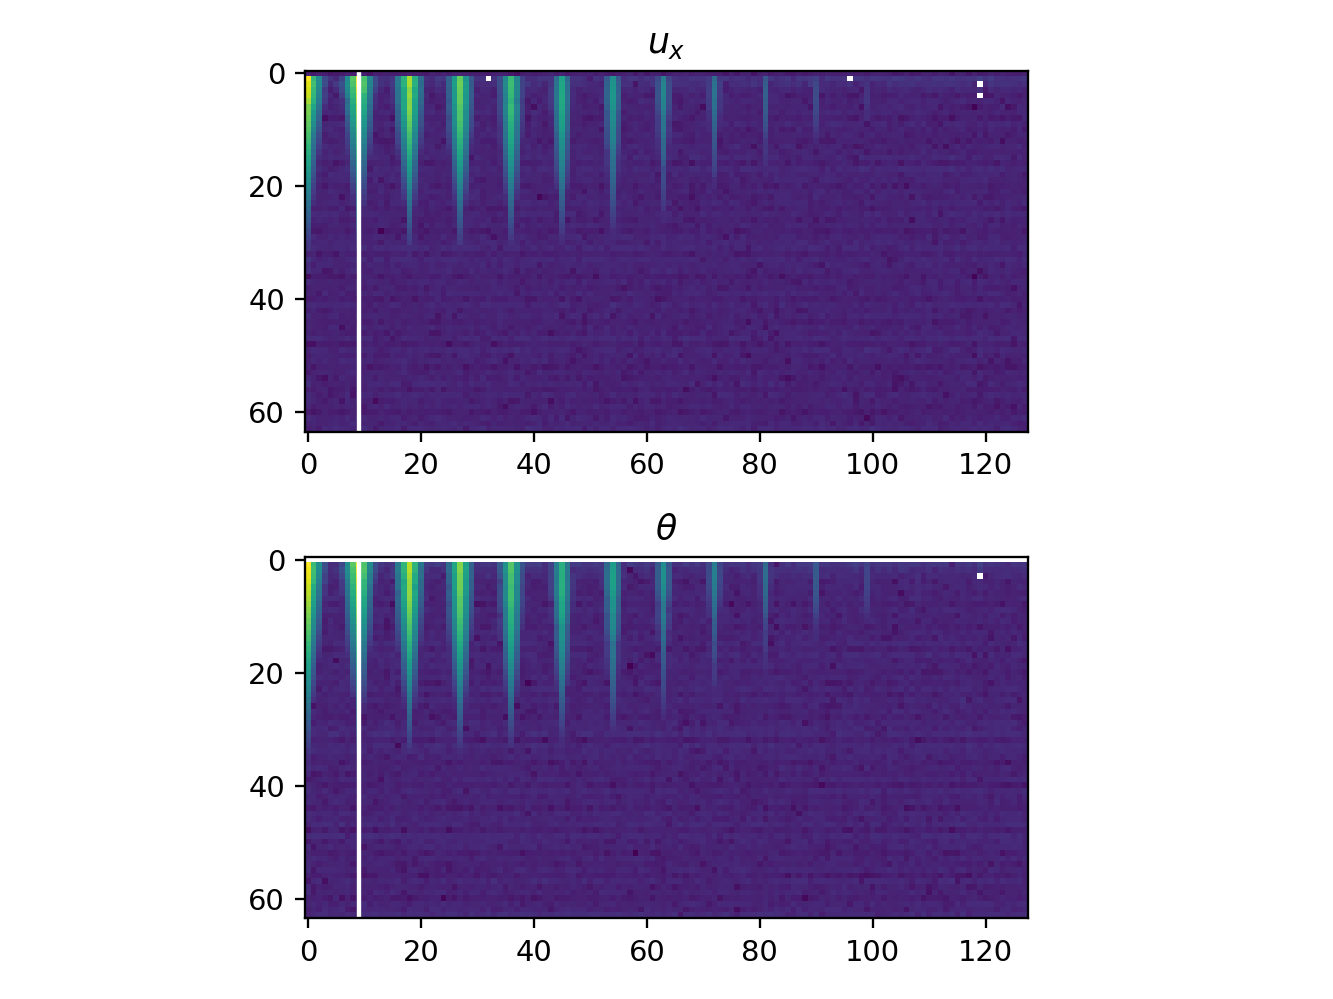

/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [8]:
plt.figure()
plt.subplot(211)
plt.imshow(np.log10(ux_spec))
plt.axvline(9,color='white')
plt.title(r"$u_x$")
plt.subplot(212)
plt.imshow(np.log10(theta_spec))
plt.axvline(9,color='white')

plt.title(r"$\theta$")
plt.tight_layout()

<IPython.core.display.Javascript object>


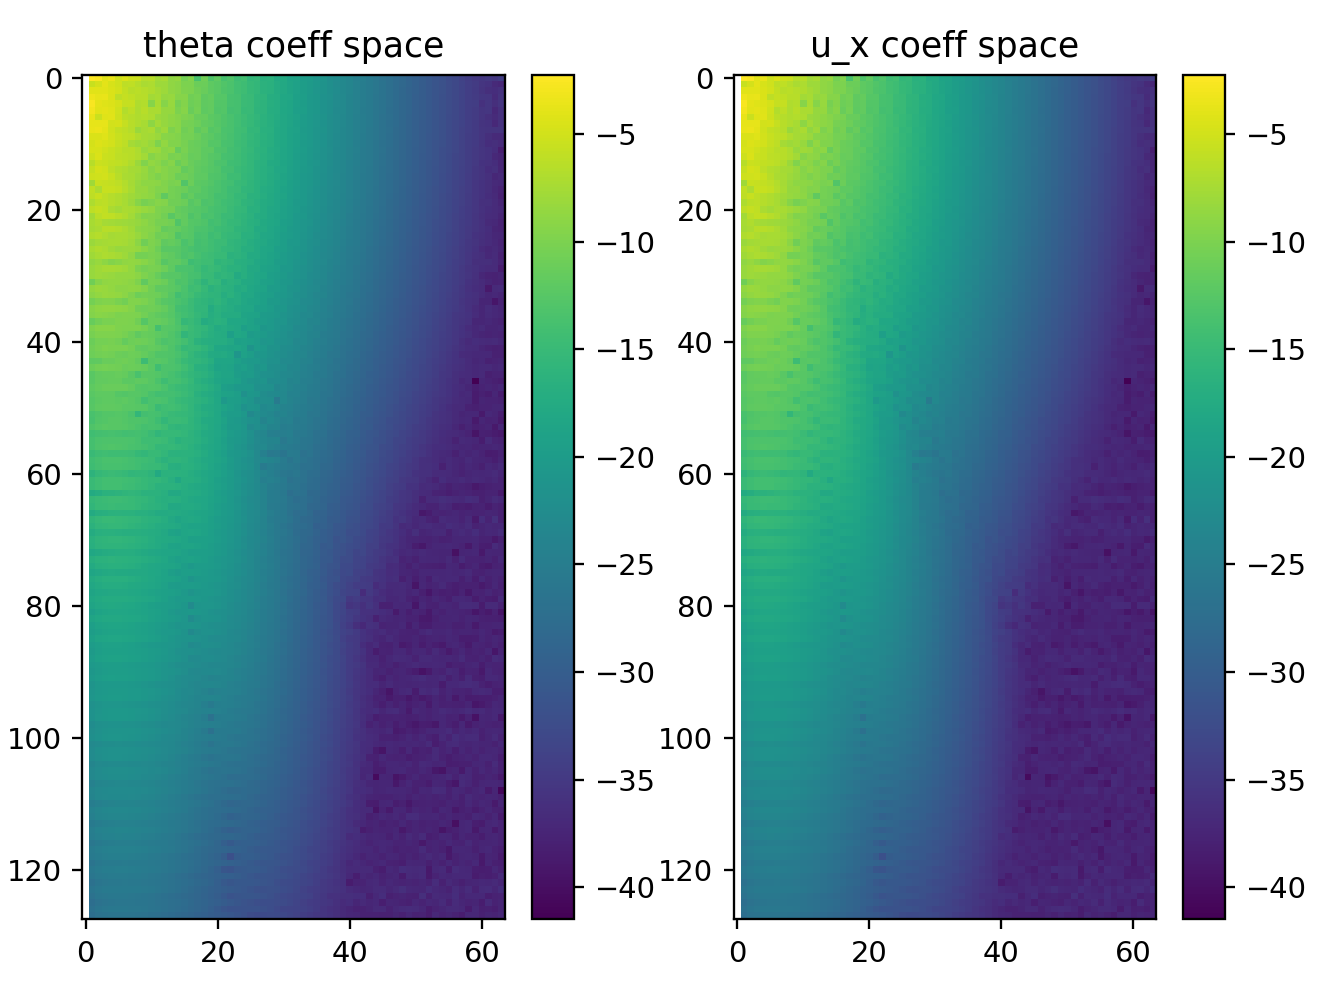

/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [58]:
plt.figure()
plt.subplot(211)
plt.imshow(np.log10(u_x_spec_2))
plt.axvline(9,color='white')
plt.title(r"$u_x$")
plt.subplot(212)
plt.imshow(np.log10(theta_spec_2))
plt.axvline(9,color='white')

plt.title(r"$\theta$")
plt.tight_layout()

<IPython.core.display.Javascript object>


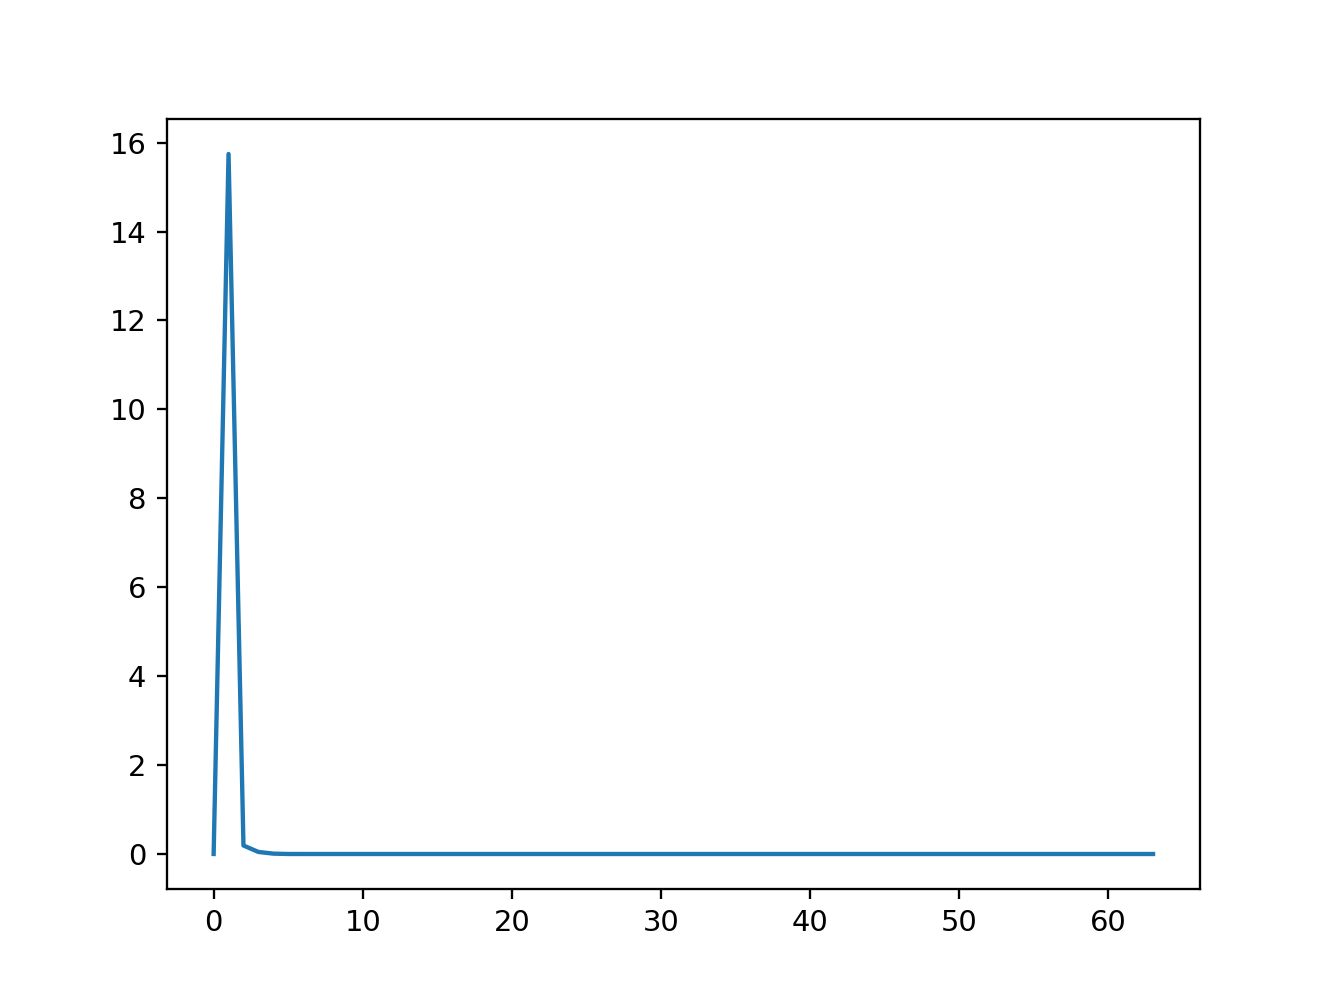

In [9]:
plt.figuare()
plt.plot(ux_spec[:,0])

In [10]:
pre_mask = np.indices((ny,nx))

mask = (pre_mask[0,...] + pre_mask[1,...]) %2 == 0
mask[0,:] = 0

In [109]:
pre_mask_xy = np.indices((nx,ny))

mask_xy = (pre_mask_xy[0,...] + pre_mask_xy[1,...]) %2 == 0
mask_xy[:,0] = 0

In [112]:
mask_xy

array([[False, False,  True, ..., False,  True, False],
       [False,  True, False, ...,  True, False,  True],
       [False, False,  True, ..., False,  True, False],
       ...,
       [False,  True, False, ...,  True, False,  True],
       [False, False,  True, ..., False,  True, False],
       [False,  True, False, ...,  True, False,  True]])

In [115]:
(mask_xy.astype(int)-mask.astype(int).T).sum()

0

<IPython.core.display.Javascript object>


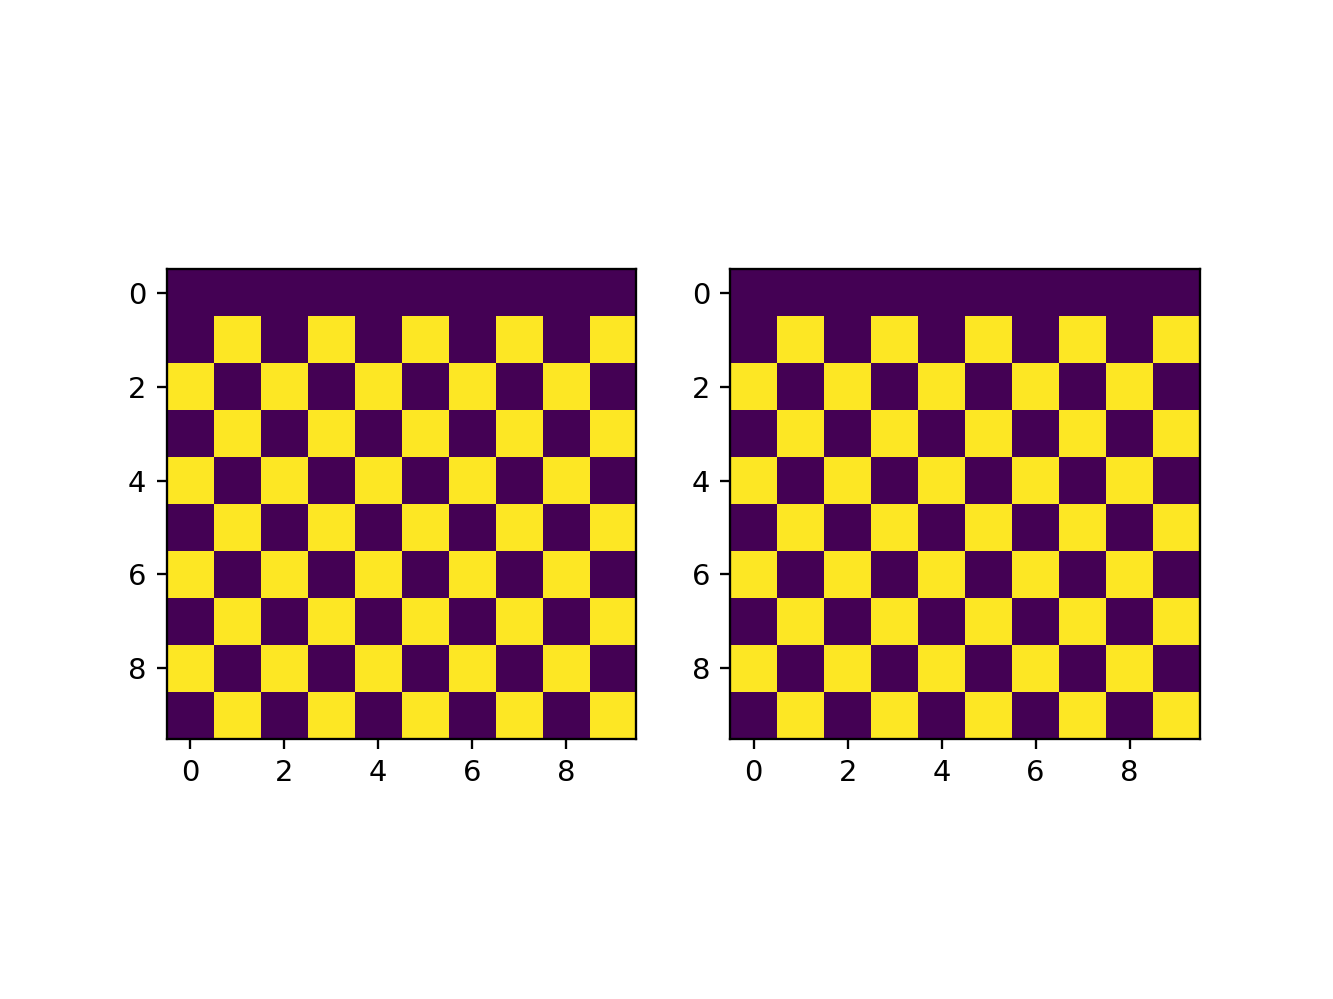

In [120]:
plt.figure()
plt.subplot(121)
plt.imshow(mask_xy[:10,:10].T)
plt.subplot(122)
plt.imshow(mask[:10,:10])

<IPython.core.display.Javascript object>


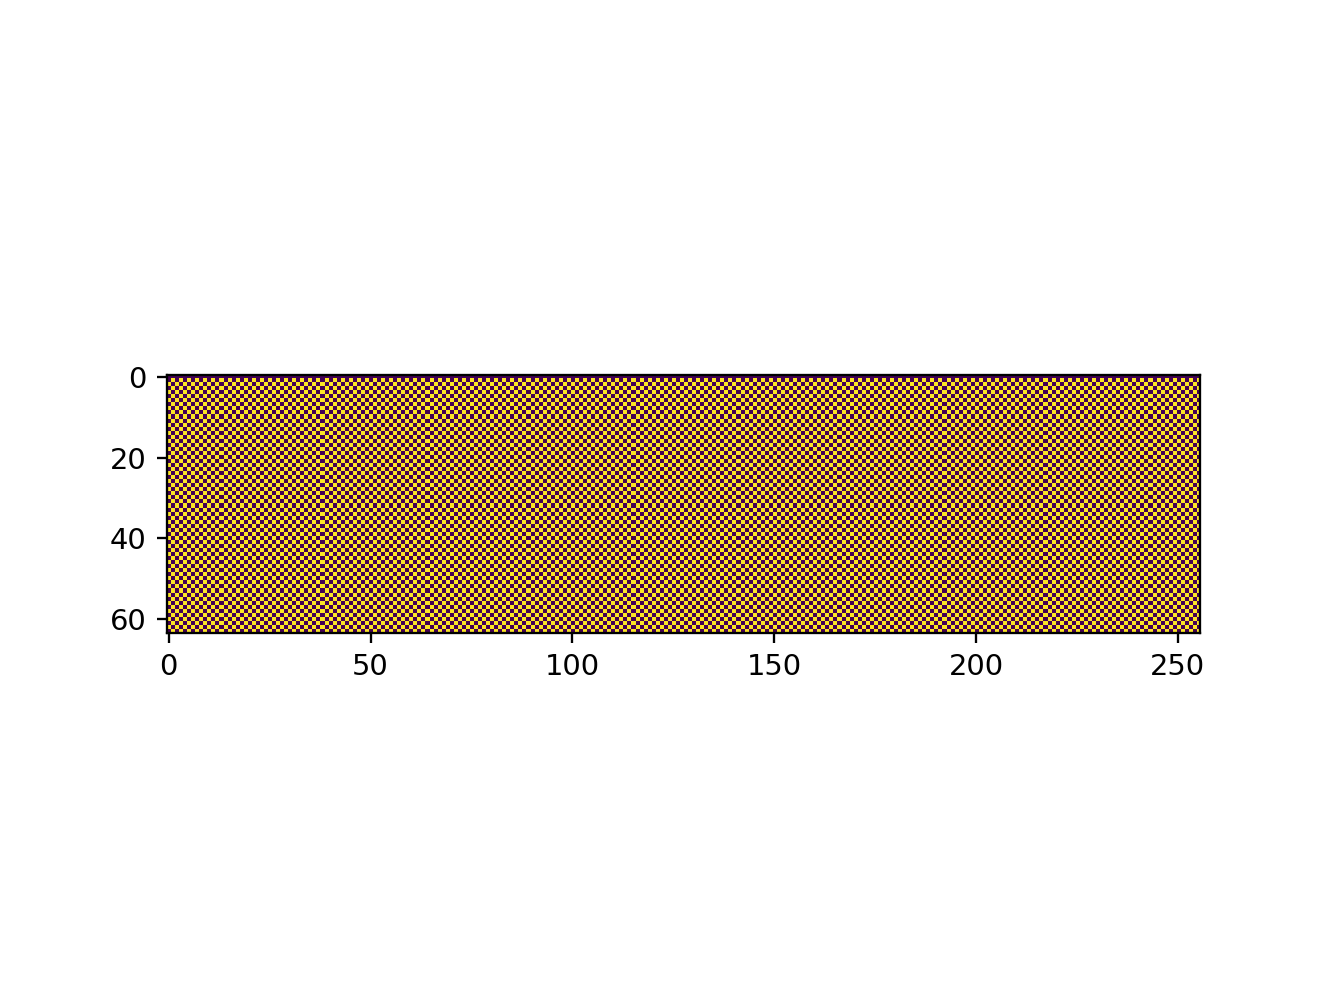

In [11]:
plt.figure()
plt.imshow(mask)

In [12]:
d.dist.coeff_layout.global_shape(scales=1)

array([ 64, 128])

In [13]:
d.dist.grid_layout.global_shape(scales=1)

array([ 64, 256])

In [14]:
theta_sym = d.new_field(name='theta')

theta_sym.meta['y']['parity'] = -1
theta_sym['g'] = df_sym['tasks/theta'][-1]
theta_sym_spec = (theta_sym['c']*theta_sym['c'].conj()).real

In [15]:
theta_sym_45 = d.new_field(name='theta')

theta_sym_45.meta['y']['parity'] = -1
theta_sym_45['g'] = df_sym_45['tasks/theta'][-1]
theta_sym_45_spec = (theta_sym_45['c']*theta_sym_45['c'].conj()).real

In [16]:
theta_sym_425 = d.new_field(name='theta')

theta_sym_425.meta['y']['parity'] = -1
theta_sym_425['g'] = df_sym_425['tasks/theta'][-1]
theta_sym_425_spec = (theta_sym_425['c']*theta_sym_425['c'].conj()).real

<IPython.core.display.Javascript object>


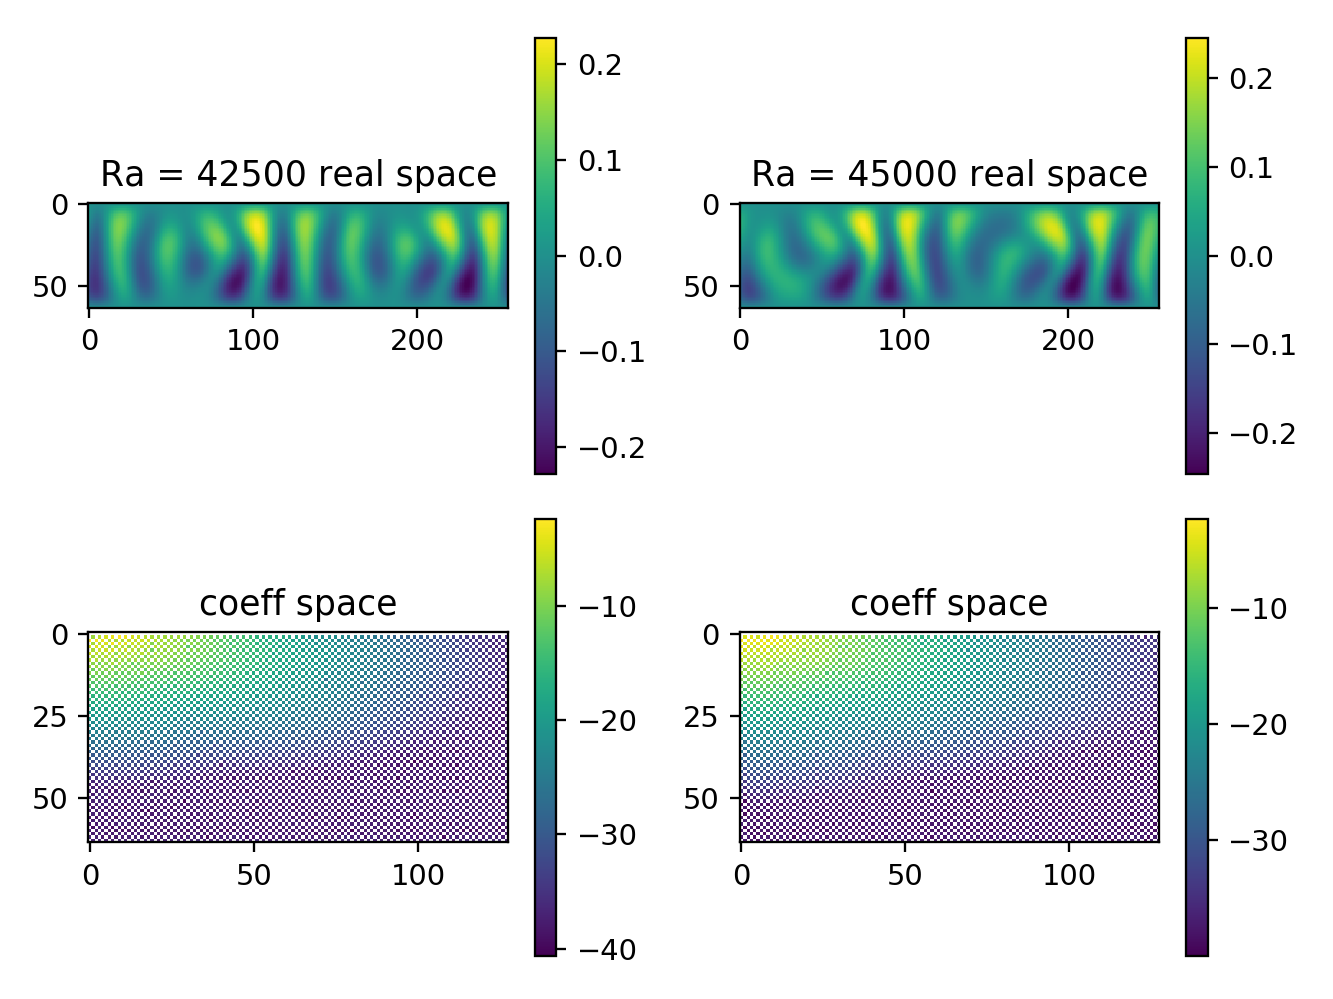

/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [17]:
plt.figure()
plt.subplot(221)
plt.imshow(df_sym_425['tasks/theta'][-1])
plt.colorbar()
plt.title('Ra = 42500 real space')
plt.subplot(222)
plt.imshow(df_sym_45['tasks/theta'][-1])
plt.title('Ra = 45000 real space')

plt.colorbar()
plt.subplot(223)
plt.imshow(np.log10(theta_sym_425_spec))
plt.title('coeff space')
plt.colorbar()
plt.subplot(224)
plt.imshow(np.log10(theta_sym_45_spec))
plt.title('coeff space')
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


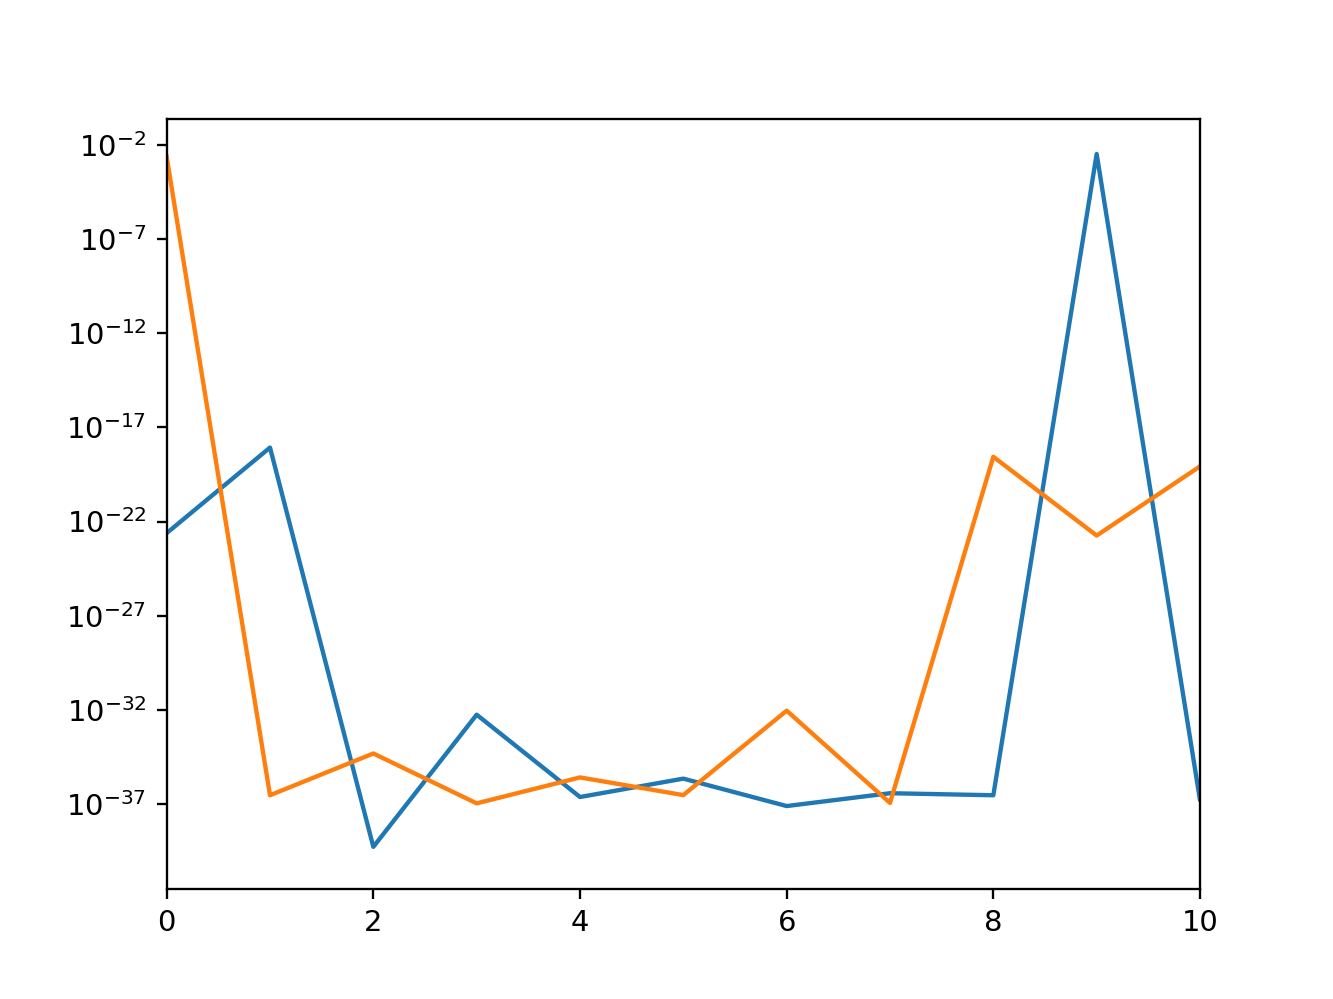

(0, 10)

In [18]:
plt.figure()
plt.semilogy(theta_sym_spec[1,:])
plt.semilogy(theta_sym_spec[2,:])
plt.xlim(0,10)

<IPython.core.display.Javascript object>


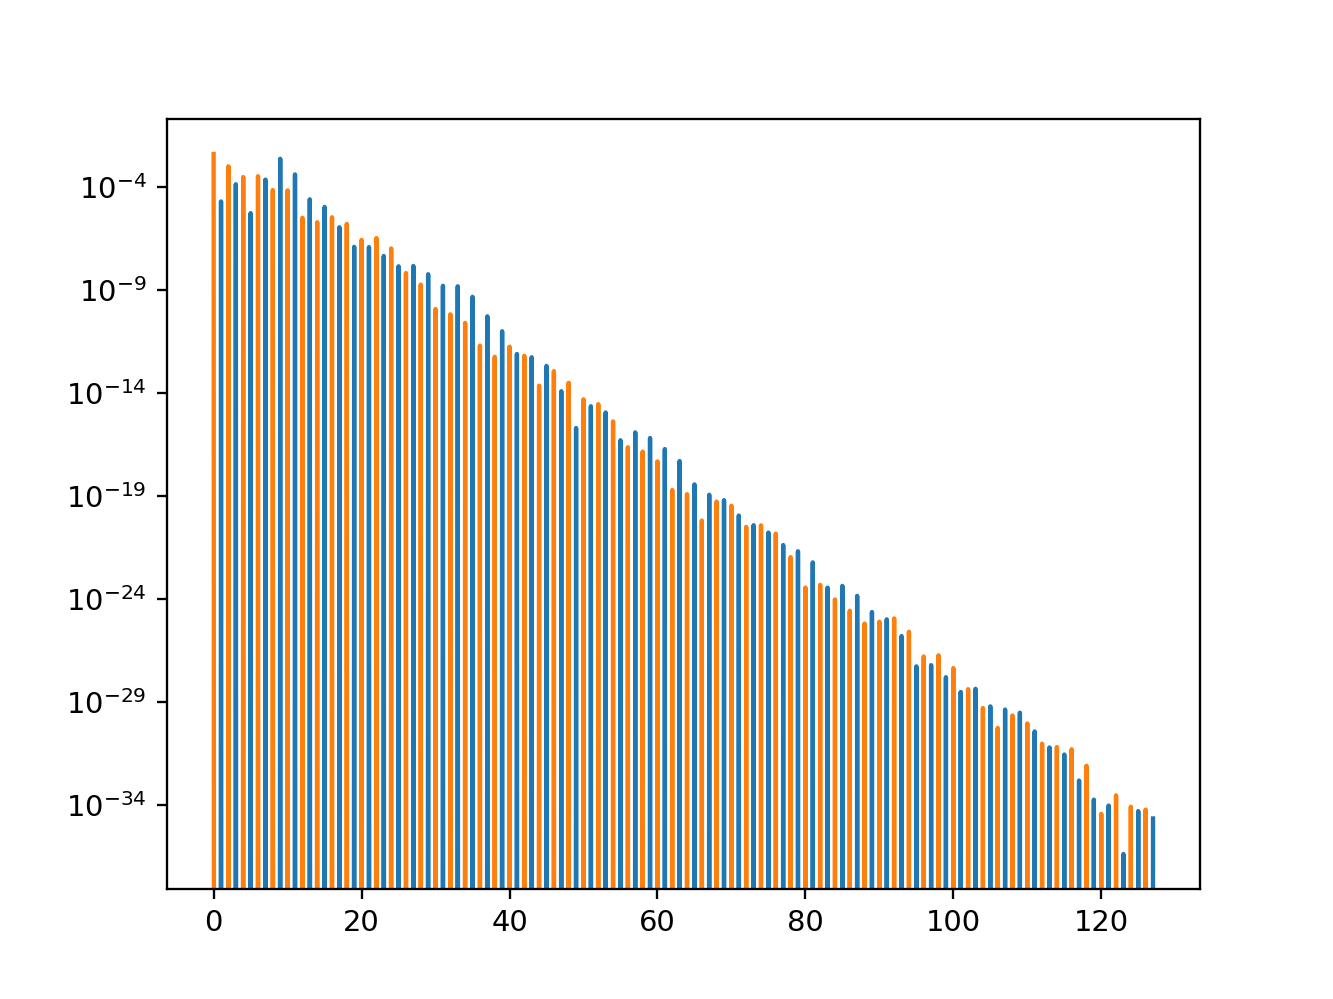

In [19]:
plt.figure()
plt.semilogy(theta_sym_45_spec[1,:])
plt.semilogy(theta_sym_45_spec[2,:])
#plt.xlim(0,10)

<IPython.core.display.Javascript object>


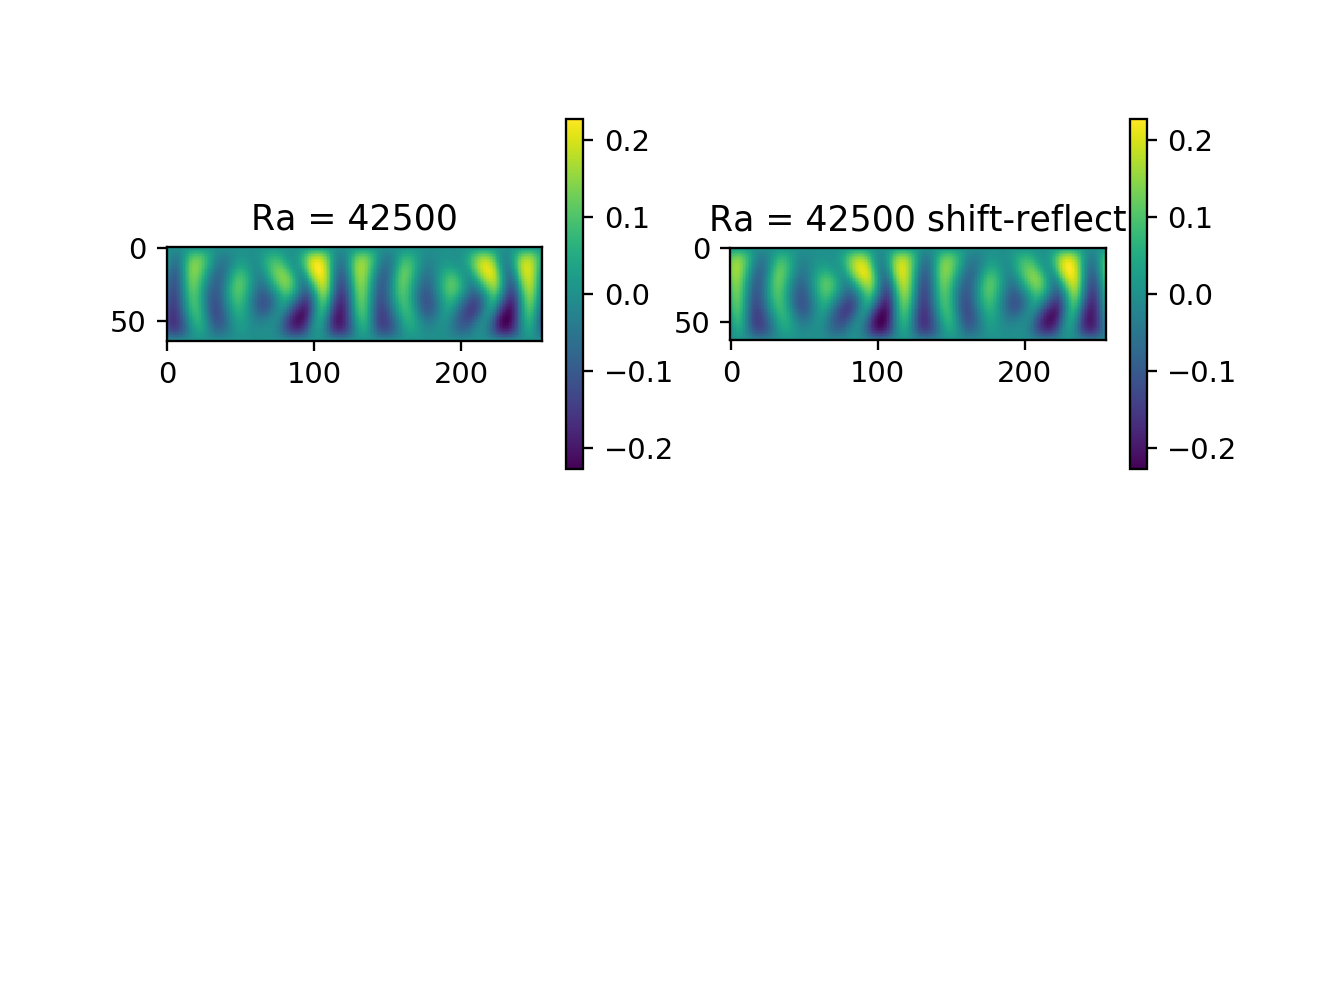

Text(0.5, 1.0, 'Ra = 42500 shift-reflect')

In [20]:
dfs425  = df_sym_425['tasks/theta'][:]
plt.figure()
plt.subplot(221)
plt.imshow(dfs425[-1])
plt.colorbar()
plt.title('Ra = 42500')
plt.subplot(222)
plt.imshow(-dfs425[-1,-1:0:-1,:])
plt.colorbar()
plt.title('Ra = 42500 shift-reflect')

Looks like Ra 42500 and 45000 keep symmetry just from initial conditions. Maybe we could see if a direct run A with symmetric ICs reaches 1S state and then see how many jets that has?

In [22]:
ts_E = h5py.File("scratch/busse_annulus_ra3.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL/timeseries/timeseries_s1.h5","r")
ts_sym = h5py.File("scratch/busse_annulus_ra3.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/timeseries/timeseries_s1.h5", "r")
ts_sym_45 = h5py.File("scratch/busse_annulus_ra4.50e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/timeseries/timeseries_s1.h5", "r")
ts_sym_425 = h5py.File("scratch/busse_annulus_ra4.25e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/timeseries/timeseries_s1.h5", "r")

In [23]:
ts_E['tasks'].keys()

<KeysViewHDF5 ['E_zonal', 'Ekdot_T', 'Ekdot_drag', 'Ekdot_visc', 'Ekin', 'Enstrophy']>

From Brummell & Hart (1993), we expect at Run E parameters (Ra = 36000, $\beta = 2800$) a 9S state to have a fixed point (constant) energy and a 9A state with a limit cycle. And that's what we find!

<IPython.core.display.Javascript object>


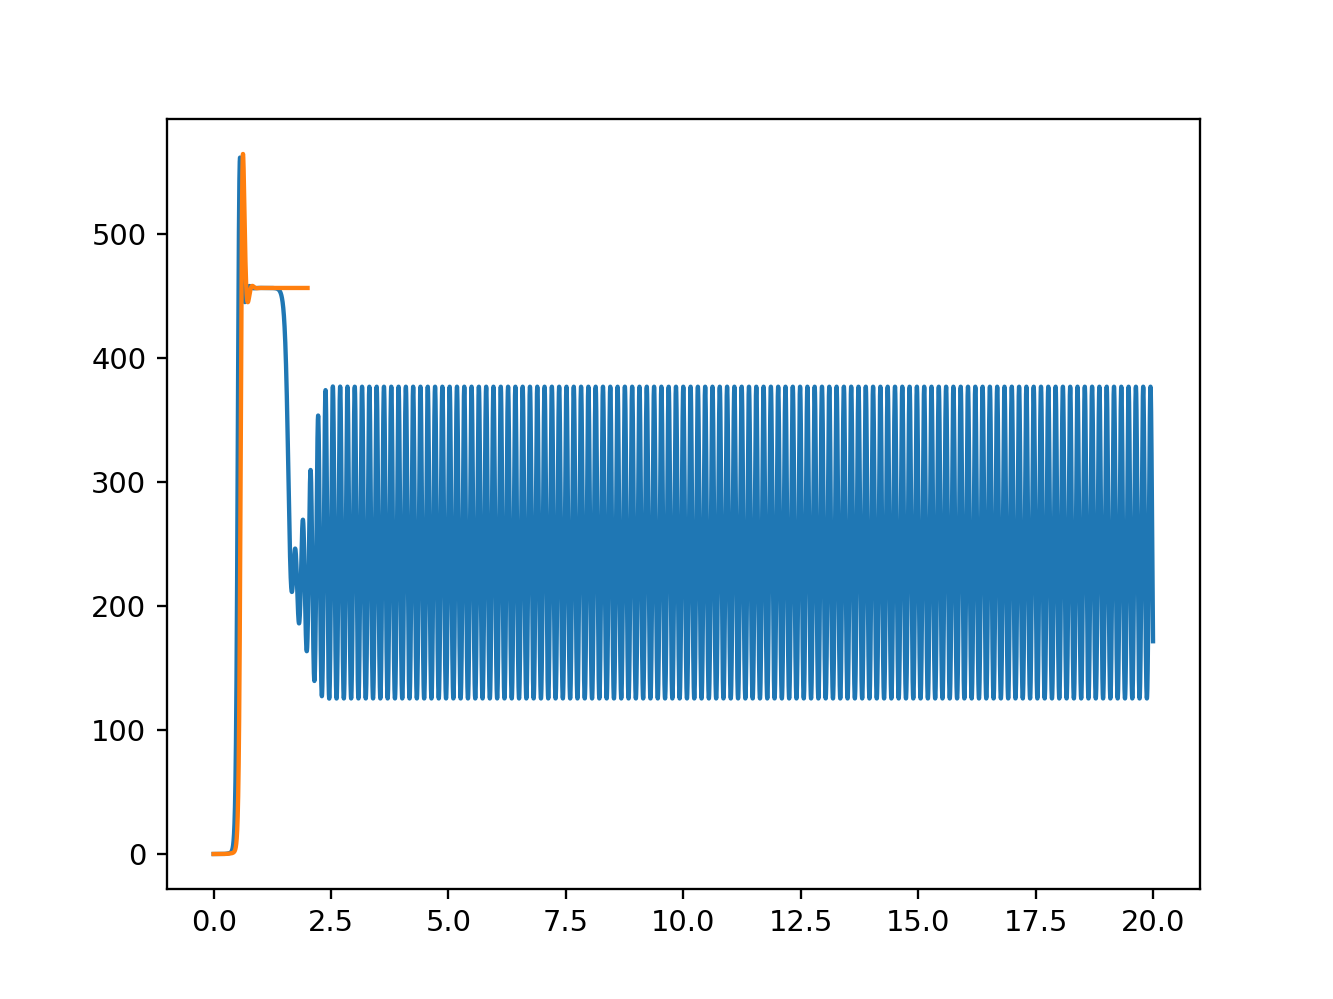

In [29]:
plt.figure()
plt.plot(ts_E['scales/sim_time'][:],ts_E['tasks/Ekin'][:,0,0])
plt.plot(ts_sym['scales/sim_time'][:],ts_sym['tasks/Ekin'][:,0,0])

For symmetry restricted simulations, at Ra = 42500, 

<IPython.core.display.Javascript object>


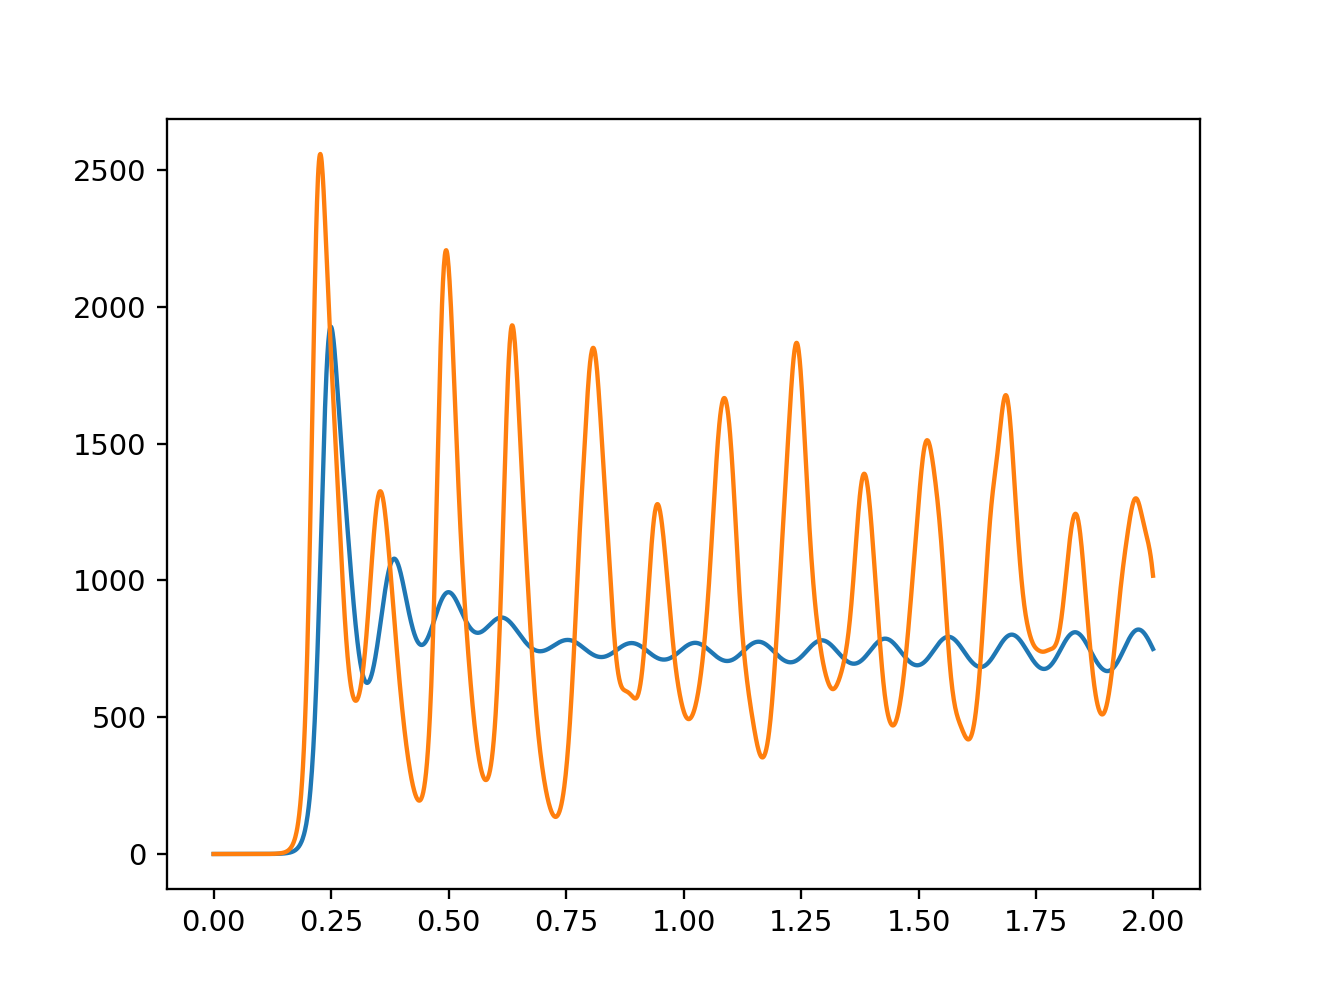

In [31]:
plt.figure()
plt.plot(ts_sym_425['scales/sim_time'][:],ts_sym_425['tasks/Ekin'][:,0,0])
plt.plot(ts_sym_45['scales/sim_time'][:],ts_sym_45['tasks/Ekin'][:,0,0])

## Run A Symmetric ICs

What happens if we just go to Ra = 76000 with symmetric ICs?

In [126]:
run_A_pow = extract_theta_ux_power("scratch/busse_annulus_ra7.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC_xy/snapshots/snapshots_s1.h5",index=0)
run_A_pow_2 = extract_theta_ux_power("scratch/busse_annulus_ra7.60e+04_beta2.80e+03_C0.00e+00_Pr1.00e+00_filter5.00e-01_nx256_ny64_CFL_symmetricIC/snapshots/snapshots_s1.h5",index=-1,xy=False)

run_E_sym_pow = extract_theta_ux_power(run_E_sym_fn,index=0,xy=False)

<IPython.core.display.Javascript object>


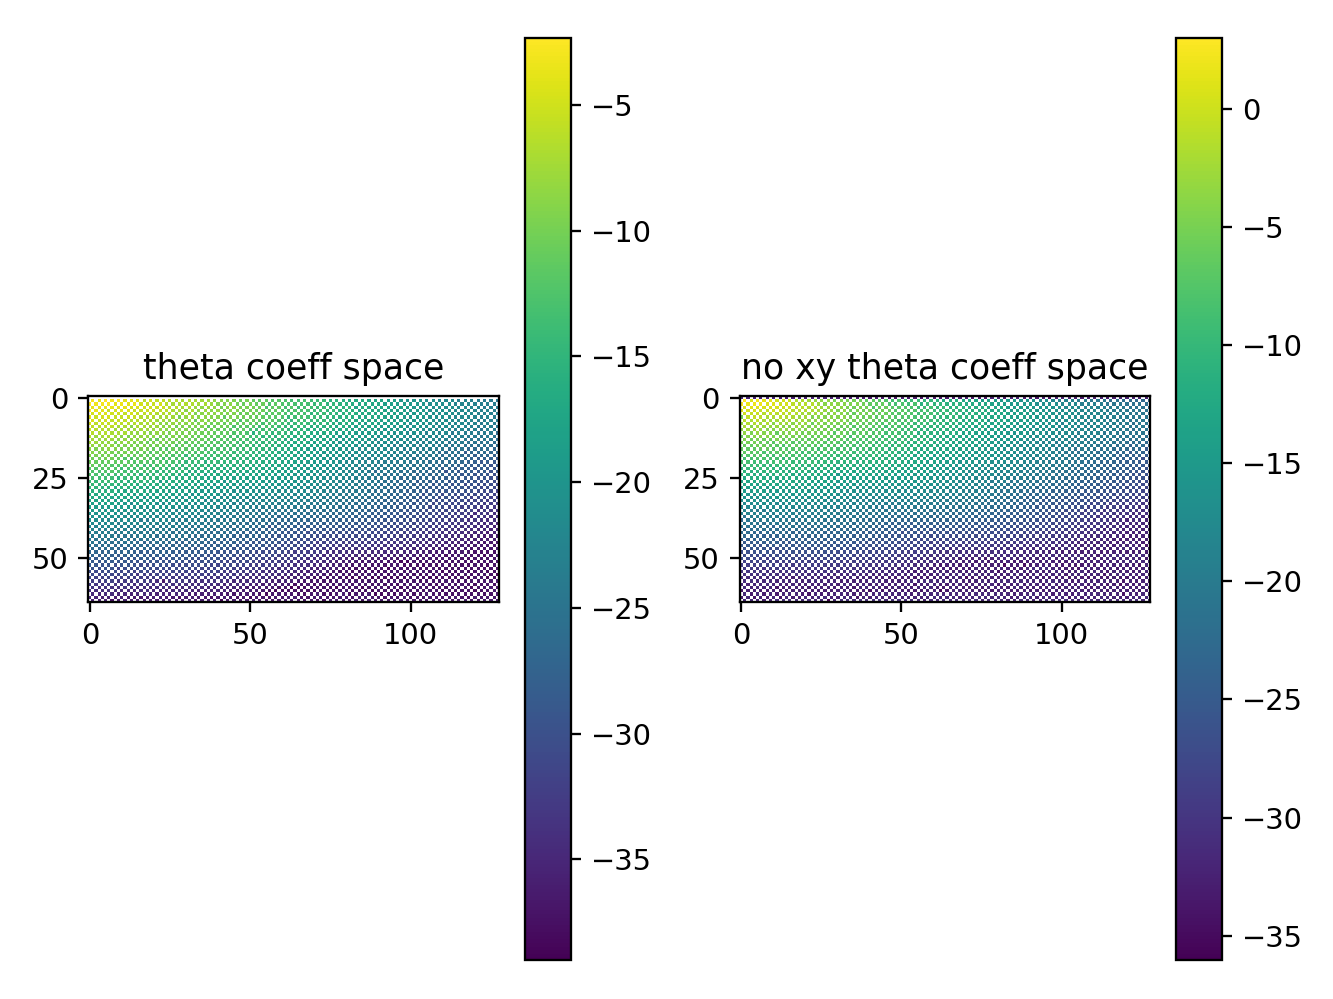

/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [127]:
plt.figure()
plt.subplot(121)
plt.imshow(np.log10(run_A_pow_2[1]))
plt.title('theta coeff space')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log10(run_A_pow_2[2]))
plt.title('no xy theta coeff space')
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


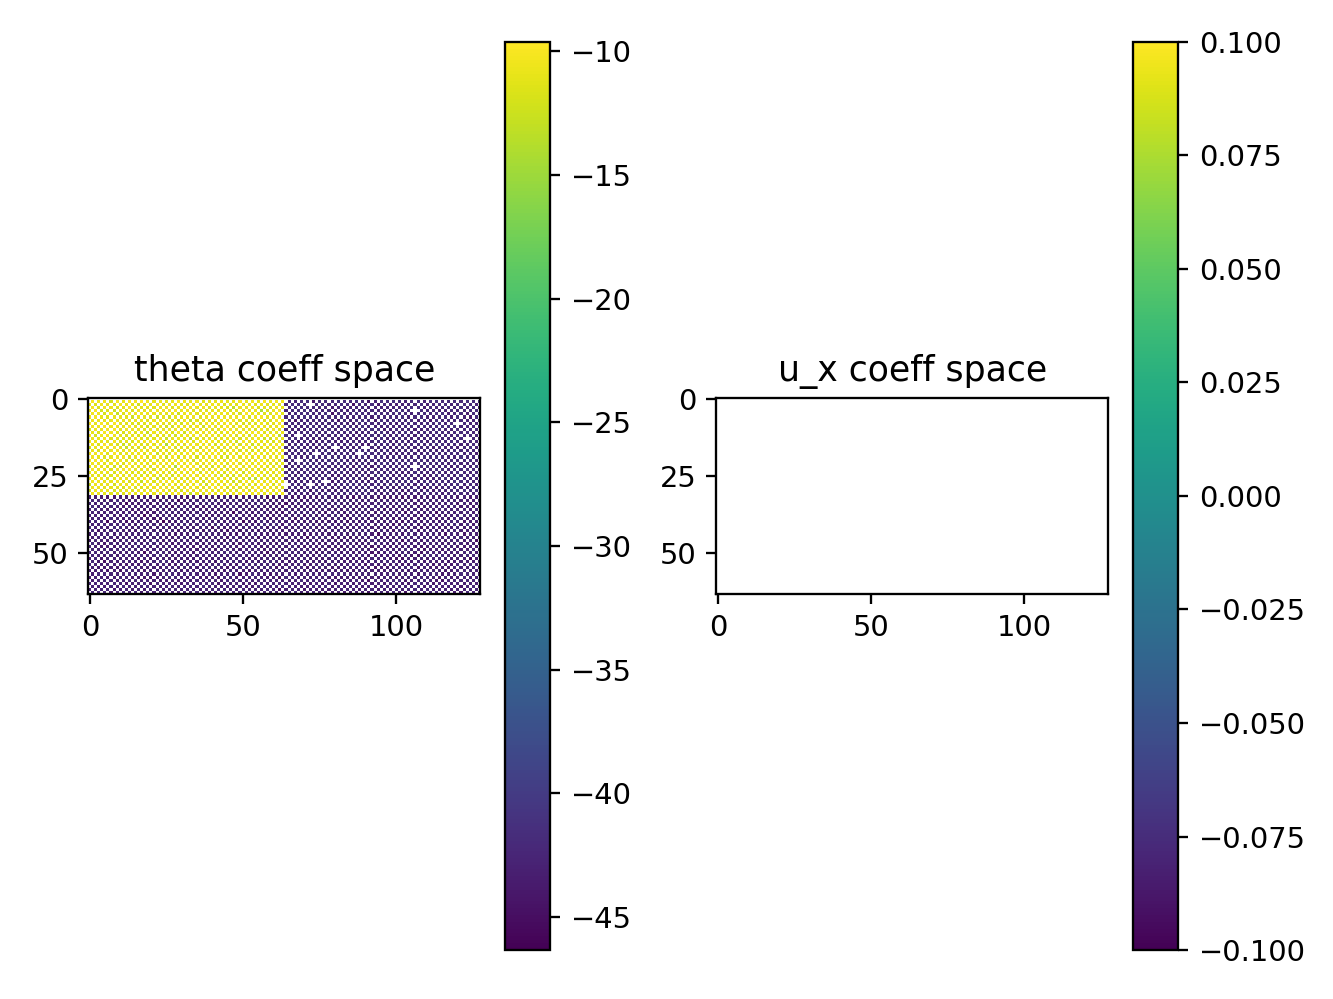

/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joishi/miniconda3/envs/dedalus/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [89]:
plt.figure()
plt.subplot(121)
plt.imshow(np.log10(run_E_sym_pow[1]))
plt.title('theta coeff space')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log10(run_E_sym_pow[2]))
plt.title('u_x coeff space')
plt.colorbar()
plt.tight_layout()